In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid

from dotenv import load_dotenv
import os


load_dotenv()
api_key2 = os.getenv("GEMINI_API_KEYY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",google_api_key=  api_key2 )

llm.invoke("hi").content



'Hi there! How can I help you today?'

In [2]:


class State(TypedDict): 
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

def model(state: State): 
    """ Here, we're using the LLM to generate a LinkedIn post with human feedback incorporated """

    print("[model] Generating content")
    linkedin_topic = state["linkedin_topic"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"]


    # Here, we define the prompt 

    prompt = f"""

        LinkedIn Topic: {linkedin_topic}
        Human Feedback: {feedback[-1] if feedback else "No feedback yet"}

        Generate a structured and well-written LinkedIn post based on the given topic.

        Consider previous human feedback to refine the reponse. 
    """

    response = llm.invoke([
        SystemMessage(content="You are an expert LinkedIn content writer"), 
        HumanMessage(content=prompt)
    ])

    geneated_linkedin_post = response.content

    print(f"[model_node] Generated post:\n{geneated_linkedin_post}\n")

    return {
       "generated_post": [AIMessage(content=geneated_linkedin_post)] , 
       "human_feedback": feedback
    }

def human_node(state: State): 
    """Human Intervention node - loops back to model unless input is done"""

    print("\n [human_node] awaiting human feedback...")

    generated_post = state["generated_post"]

    # Interrupt to get user feedback

    user_feedback = interrupt(
        {
            "generated_post": generated_post, 
            "message": "Provide feedback or type 'done' to finish"
        }
    )

    print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.lower() == "done": 
        return Command(update={"human_feedback": state["human_feedback"] + ["Finalised"]}, goto="end_node")

    # Otherwise, update feedback and return to model for re-generation
    return Command(update={"human_feedback": state["human_feedback"] + [user_feedback]}, goto="model")


def end_node(state: State): 
    """ Final node """
    print("\n[end_node] Process finished")
    print("Final Generated Post:", state["generated_post"][-1])
    print("Final Human Feedback", state["human_feedback"])
    return {"generated_post": state["generated_post"], "human_feedback": state["human_feedback"]}


# Buiding the Graph

graph = StateGraph(State)
graph.add_node("model", model)
graph.add_node("human_node", human_node)
graph.add_node("end_node", end_node)

graph.set_entry_point("model")

# Define the flow

graph.add_edge(START, "model")
graph.add_edge("model", "human_node")

graph.set_finish_point("end_node")

# Enable Interrupt mechanism
checkpointer = MemorySaver()


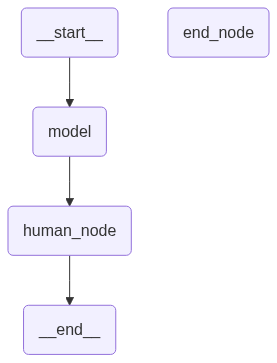

In [3]:
graph.compile()

In [4]:
app = graph.compile(checkpointer=checkpointer)

thread_config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

linkedin_topic = input("Enter your LinkedIn topic: ")
initial_state = {
    "linkedin_topic": linkedin_topic, 
    "generated_post": [], 
    "human_feedback": []
}


for chunk in app.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        #  If we reach an interrupt, continuously ask for human feedback

        if(node_id == "__interrupt__"):
            while True: 
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                app.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break




[model] Generating content
[model_node] Generated post:
## Level Up Your AI: The Rise of Agentic AI

The future of AI is here, and it's taking a decidedly **agentic** turn. We're moving beyond passive tools and towards AI systems that are capable of *autonomously planning, reasoning, and acting* to achieve complex goals.

But what exactly *is* agentic AI, and why should you care?

**Here's a breakdown:**

*   **What is Agentic AI?** Unlike traditional AI that responds to specific prompts, agentic AI can:
    *   **Set its own goals:** Driven by defined objectives, it proactively seeks solutions.
    *   **Plan and strategize:** Devising multi-step action plans to reach those goals.
    *   **Learn and adapt:** Continuously improving its performance through experience.
    *   **Utilize tools:** Accessing and leveraging external resources (databases, APIs, etc.) to complete tasks.

*   **Why it Matters:** Agentic AI is poised to revolutionize:
    *   **Automation:** Automating complex 